In [1]:
# Carga inicial de librerías
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from sklearn.metrics import mean_absolute_error, mean_squared_error
from keras import regularizers

In [2]:
def get_X_y(datos, dias):
    
    X, y = [], []
    
    for i in range(len(datos) - dias):
        X.append(datos[i:(i + dias), :])
        y.append(datos[i + dias, 0])
        
    return np.array(X), np.array(y)

def visualizar_pred_test(y_test, y_pred, fechas, tit):
    plt.figure(figsize=(16, 6))
    plt.plot(fechas, y_test, label='Test', color='green')
    plt.plot(fechas, y_pred, label='Predicciones', color='orange')
    plt.xticks(rotation=60)
    plt.xlabel('Fechas')
    plt.ylabel('Número de casos de COVID')
    plt.title(tit)
    plt.legend()
    plt.show()
    
def visualizar_historico(train, test, pred, variable, dias_historico, indices, tit):
    train_s = train.iloc[len(train) - dias_historico:]
    color_isla = 'gray'
    
    plt.figure(figsize=(10, 6))
    if variable != '':
        plt.plot(train_s.index, train_s[variable], label='Train', color=color_isla)
    else:
        plt.plot(train_s.index, train_s, label='Train', color=color_isla)
    plt.plot(indices, y_test, label='Test', color='green')
    plt.plot(indices, y_pred, label='Predicciones', color='orange')
    
    
    plt.xticks(np.arange(0, len(train_s.index)  + len(indices), step=5),   train_s.index.union(indices)[::5], rotation=60)

    plt.legend()
    plt.title(tit)
    plt.xlabel('Fecha')
    plt.ylabel('Número de casos de COVID')
    plt.show()
    
def obtener_modelo_red_neuronal(X_train, y_train, X_test, y_test):
    modelo = Sequential()
    neurons= X_train.shape[1]
    modelo.add(LSTM(X_train.shape[1] * X_train.shape[2], 
                   activation='relu',
                   return_sequences=True, 
                   input_shape=(X_train.shape[1], X_train.shape[2])))
    modelo.add(Dropout(0.2))
    modelo.add(LSTM(50, 
                   activation='relu',
                   return_sequences=True))
    modelo.add(Dropout(0.2))
    modelo.add(LSTM(25, 
                   activation='relu',
                   return_sequences=False))
    modelo.add(Dropout(0.2))
    #modelo.add(Dense(5, activation='relu'))
    modelo.add(Dense(units=1, kernel_regularizer=regularizers.l2(0.01)))
    modelo.compile(optimizer='rmsprop', loss='mean_squared_error')
    modelo.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=50, batch_size=64, verbose=1)
    
    return modelo
    
def obtener_errores(y_true, y_pred):
    ''' Método que devuelvo los errores:
            * MAE: Error absoluto medio
            * MSE: Error cuadrático medio
            * RMSE: Raíz del error cuadrático medio
    
    Args:
        y_true (Serie): Valores reales del conjunto de test
        y_pred (Serie): Valores predichos por el modelo
    Return:
        mae(float): Error absoluto medio
        mse(float): Error cuadrático medio
        rmse(float): Raíz del error cuadrático medio
    '''
    
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    
    return mae, mse, rmse

def visualizar_resultados_texto(y_test, y_pred, fechas):
    for i in range(len(y_test)):
        print(str(fechas[i]) + ': número de casos reales ' + str(int(y_test[i][0])) + ', número de casos predichos ' + str(y_pred[i][0]))

In [3]:
# Cargamos los datos de las estaciones de cada una de las islas
datos = pd.read_csv('../data/Final/datos_final.csv', header=0)
datos_GranCanaria = datos[datos['isla'] == 'GRAN CANARIA']
datos_GranCanaria = datos_GranCanaria.set_index('fecha')

In [4]:
# Variables globales a utilizar en todo el proceso

variables_covid = ['pcr_total', 'Urg_cv', 'HPT_cv19', 'CCR_cv19']      # Atributos para el análisis de las variables pandémicas
variables_atm = ['tmin', 'tmed', 'presMax']                              # Atributos para el análisis de las variables atmosféricas
variables = ['pcr_total', 'Urg_cv', 'HPT_cv19', 'CCR_cv19','tmin', 'tmed', 'presMax']  # Atributos para el análisis de todas las variables


objetivo = 'numero_casos' # Variable objetivo
dias_prediccion = 10      # días a agrupar 
isla = 'Gran Canaria'     # Isla a la que se está realziando el estudio
fechas = datos_GranCanaria.tail(dias_prediccion).index # Fechas de los días a predecir

In [5]:
datos_GranCanaria_uni = datos_GranCanaria[objetivo]
datos_GranCanaria_uni_arr = np.array(datos_GranCanaria_uni).reshape(-1, 1)

datos_GranCanaria_mult_covid = datos_GranCanaria[[objetivo, 'pcr_total', 'Urg_cv', 'HPT_cv19', 'CCR_cv19']]
datos_GranCanaria_mult_atm = datos_GranCanaria[[objetivo, 'tmin', 'tmed', 'presMax']]
datos_GranCanaria_mult_total = datos_GranCanaria[[objetivo, 'pcr_total', 'Urg_cv', 'HPT_cv19', 'CCR_cv19','tmin', 'tmed', 'presMax']]

# Red Neuronal Recurrente univariable

In [6]:
scaler = MinMaxScaler(feature_range=(0, 1))
datos_GranCanaria_uni_scaled = scaler.fit_transform(datos_GranCanaria_uni_arr)

In [7]:
n_train = len(datos_GranCanaria_uni_scaled) - dias_prediccion


train = datos_GranCanaria_uni_scaled[0:n_train, :]

# Para obtener el conjunto de test obtenemos los 10 días anteriores a test para poder conformar el problema supervisado
test = datos_GranCanaria_uni_scaled[n_train - dias_prediccion:len(datos_GranCanaria_uni_scaled), :]

In [8]:
X_train, y_train = get_X_y(train, dias_prediccion)
X_test, y_test = get_X_y(test, dias_prediccion)

X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

In [9]:
modelo = obtener_modelo_red_neuronal(X_train, y_train, X_test, y_test)

Epoch 1/50


C:\Users\jalon\anaconda3\envs\tfm\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 110ms/step - loss: 0.0548 - val_loss: 0.0777
Epoch 2/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0534 - val_loss: 0.0628
Epoch 3/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0485 - val_loss: 0.0534
Epoch 4/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0421 - val_loss: 0.0518
Epoch 5/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0390 - val_loss: 0.0441
Epoch 6/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0324 - val_loss: 0.0412
Epoch 7/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0305 - val_loss: 0.0373
Epoch 8/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0255 - val_loss: 0.0293
Epoch 9/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0262 - val_loss: 0.0333
Epoch 10/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0209 - val_loss: 0.0256
Epoch 11/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0187 - val_loss: 0.0293
Epoch 12/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0170 - val_loss: 0.0262
Epoch 13/50

In [10]:
test_pred = modelo.predict(X_test)
y_pred = scaler.inverse_transform(test_pred)
y_test = scaler.inverse_transform(y_test.reshape(-1,1))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 376ms/step


In [11]:
visualizar_resultados_texto(y_test, y_pred, fechas)

array([[470.5508 ],
       [476.34152],
       [483.6829 ],
       [504.85962],
       [571.63513],
       [644.9156 ],
       [684.21497],
       [726.79517],
       [770.99   ],
       [786.7307 ]], dtype=float32)

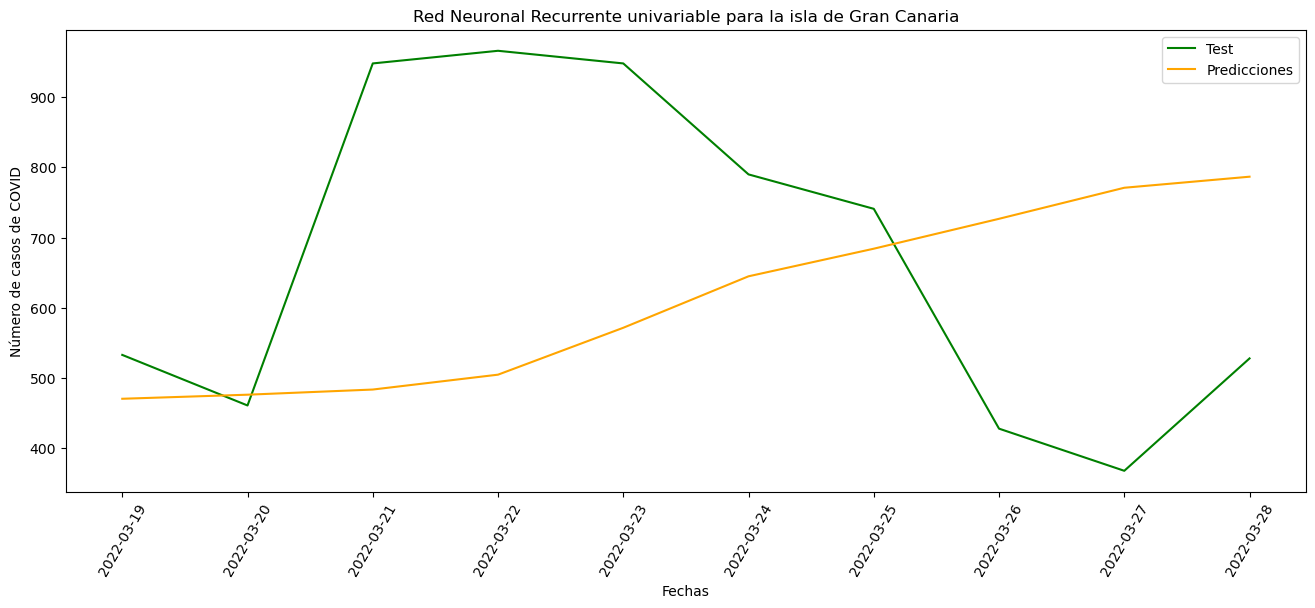

In [13]:
isla = 'Gran Canaria'
fechas = datos_GranCanaria.tail(dias_prediccion).index
tit = 'Red Neuronal Recurrente univariable para la isla de ' + isla

visualizar_pred_test(y_test, y_pred, fechas, tit)

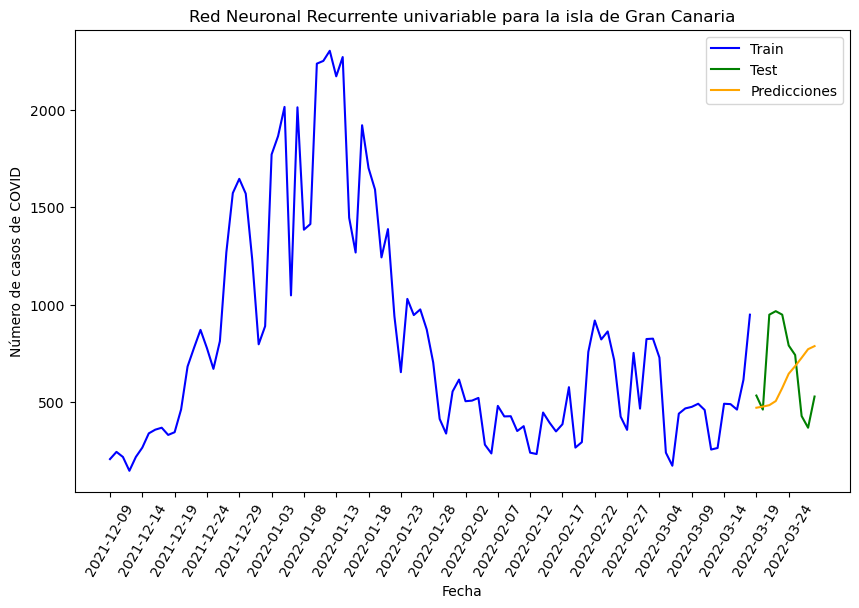

In [14]:
datos_train = datos_GranCanaria_uni.iloc[:n_train]
visualizar_historico(datos_train,y_test,y_pred,'',100,fechas,tit)

In [15]:
mae, mse, rmse = obtener_errores(y_test, y_pred)

print("Error cuadrático medio (MSE) del modelo: " + str(mse))
print("Error absoluto medio (MAE) del modelo: " + str(mae))
print("Raíz del error cuadrático medio (RMSE) del modelo: " + str(rmse))

Error cuadrático medio (MSE) del modelo: 91692.16970453924
Error absoluto medio (MAE) del modelo: 254.19983825683593
Raíz del error cuadrático medio (RMSE) del modelo: 302.80714936166754


# Red Neuronal Recurrente multivariable con variables de pandemia

In [16]:
datos_GranCanaria_mult_covid = datos_GranCanaria[[objetivo, 'pcr_total', 'Urg_ingr', 'HPT_cv19', 'CCR_cv19']]
scaler = MinMaxScaler(feature_range=(0, 1))
datos_GranCanaria_mult_covid_scaled = scaler.fit_transform(datos_GranCanaria_mult_covid)

In [17]:
# Escalador para las predicciones y test
scaler_preds = MinMaxScaler(feature_range=(0, 1))
datos_GranCanaria_mult_covid_scaled_obj = scaler_preds.fit_transform(np.array(datos_GranCanaria_mult_covid[objetivo]).reshape(-1, 1))

In [18]:
n_train = len(datos_GranCanaria_mult_covid_scaled) - dias_prediccion


train = datos_GranCanaria_mult_covid_scaled[0:n_train, :]

# Para obtener el conjunto de test obtenemos los 10 días anteriores a test para poder conformar el problema supervisado
test = datos_GranCanaria_mult_covid_scaled[n_train - dias_prediccion:len(datos_GranCanaria_mult_covid_scaled), :]

In [19]:
X_train, y_train = get_X_y(train, dias_prediccion)
X_test, y_test = get_X_y(test, dias_prediccion)

X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], X_train.shape[2]))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], X_test.shape[2]))

In [20]:
modelo = obtener_modelo_red_neuronal(X_train, y_train, X_test, y_test)

Epoch 1/50


C:\Users\jalon\anaconda3\envs\tfm\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 5s 113ms/step - loss: 0.0547 - val_loss: 0.0621
Epoch 2/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0453 - val_loss: 0.0581
Epoch 3/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0476 - val_loss: 0.0542
Epoch 4/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0382 - val_loss: 0.0544
Epoch 5/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0325 - val_loss: 0.0510
Epoch 6/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0309 - val_loss: 0.0460
Epoch 7/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0275 - val_loss: 0.0452
Epoch 8/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0254 - val_loss: 0.0381
Epoch 9/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0249 - val_loss: 0.0366
Epoch 10/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0273 - val_loss: 0.0538
Epoch 11/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0249 - val_loss: 0.0395
Epoch 12/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0258 - val_loss: 0.0466
Epoch 13/50

In [21]:
test_pred = modelo.predict(X_test)
y_pred = scaler_preds.inverse_transform(test_pred)
y_test = scaler_preds.inverse_transform(y_test.reshape(-1,1))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 349ms/step


In [22]:
visualizar_resultados_texto(y_test, y_pred, fechas)

array([[315.2013 ],
       [334.16827],
       [349.30084],
       [376.83295],
       [423.7879 ],
       [481.34668],
       [522.61145],
       [560.0251 ],
       [606.2601 ],
       [623.25494]], dtype=float32)

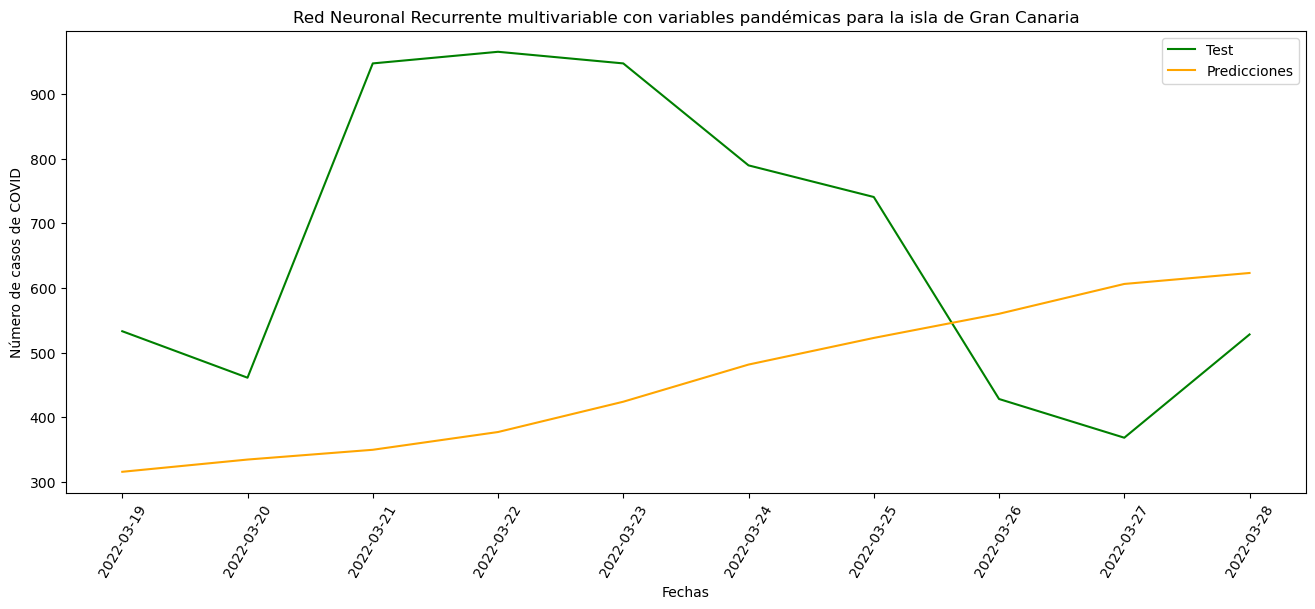

In [23]:
tit = 'Red Neuronal Recurrente multivariable con variables pandémicas para la isla de ' + isla

visualizar_pred_test(y_test, y_pred, fechas, tit)

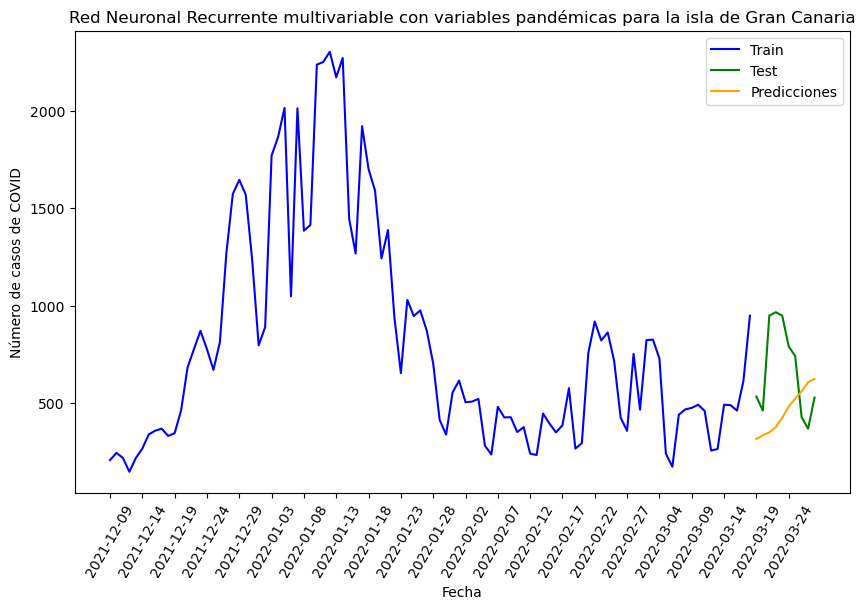

In [24]:
datos_train = datos_GranCanaria_mult_covid.iloc[:n_train, :]
visualizar_historico(datos_train,y_test,y_pred,objetivo,100,fechas,tit)

In [25]:
mae, mse, rmse = obtener_errores(y_test, y_pred)

print("Error cuadrático medio (MSE) del modelo: " + str(mse))
print("Error absoluto medio (MAE) del modelo: " + str(mae))
print("Raíz del error cuadrático medio (RMSE) del modelo: " + str(rmse))

Error cuadrático medio (MSE) del modelo: 127011.18036458455
Error absoluto medio (MAE) del modelo: 304.9290710449219
Raíz del error cuadrático medio (RMSE) del modelo: 356.3862797086675


# Red Neuronal Recurrente multivariable con variables atmosféricas

In [26]:
scaler = MinMaxScaler(feature_range=(0, 1))
datos_GranCanaria_mult_atm_scaled = scaler.fit_transform(datos_GranCanaria_mult_atm)

# Escalador par alas predicciones y test
scaler_preds = MinMaxScaler(feature_range=(0, 1))
datos_GranCanaria_mult_atm_scaled_obj = scaler_preds.fit_transform(np.array(datos_GranCanaria_mult_atm[objetivo]).reshape(-1, 1))

In [27]:
n_train = len(datos_GranCanaria_mult_atm_scaled) - dias_prediccion


train = datos_GranCanaria_mult_atm_scaled[0:n_train, :]

# Para obtener el conjunto de test obtenemos los 10 días anteriores a test para poder conformar el problema supervisado
test = datos_GranCanaria_mult_atm_scaled[n_train - dias_prediccion:len(datos_GranCanaria_mult_atm_scaled), :]

In [28]:
X_train, y_train = get_X_y(train, dias_prediccion)
X_test, y_test = get_X_y(test, dias_prediccion)

X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], X_train.shape[2]))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], X_test.shape[2]))

In [29]:
modelo = obtener_modelo_red_neuronal(X_train, y_train, X_test, y_test)

Epoch 1/50


C:\Users\jalon\anaconda3\envs\tfm\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 5s 96ms/step - loss: 0.0567 - val_loss: 0.0571
Epoch 2/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0403 - val_loss: 0.0435
Epoch 3/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0323 - val_loss: 0.0347
Epoch 4/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0314 - val_loss: 0.0321
Epoch 5/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0252 - val_loss: 0.0320
Epoch 6/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0242 - val_loss: 0.0265
Epoch 7/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0222 - val_loss: 0.0277
Epoch 8/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0250 - val_loss: 0.0323
Epoch 9/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0211 - val_loss: 0.0261
Epoch 10/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0204 - val_loss: 0.0251
Epoch 11/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0213 - val_loss: 0.0317
Epoch 12/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0189 - val_loss: 0.0338
Epoch 13/50


In [30]:
test_pred = modelo.predict(X_test)
y_pred = scaler_preds.inverse_transform(test_pred)
y_test = scaler_preds.inverse_transform(y_test.reshape(-1,1))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 463ms/step


In [31]:
visualizar_resultados_texto(y_test, y_pred, fechas)

array([[513.11487],
       [519.88855],
       [532.52106],
       [559.7251 ],
       [615.76483],
       [671.9704 ],
       [728.55115],
       [775.10583],
       [803.748  ],
       [798.38257]], dtype=float32)

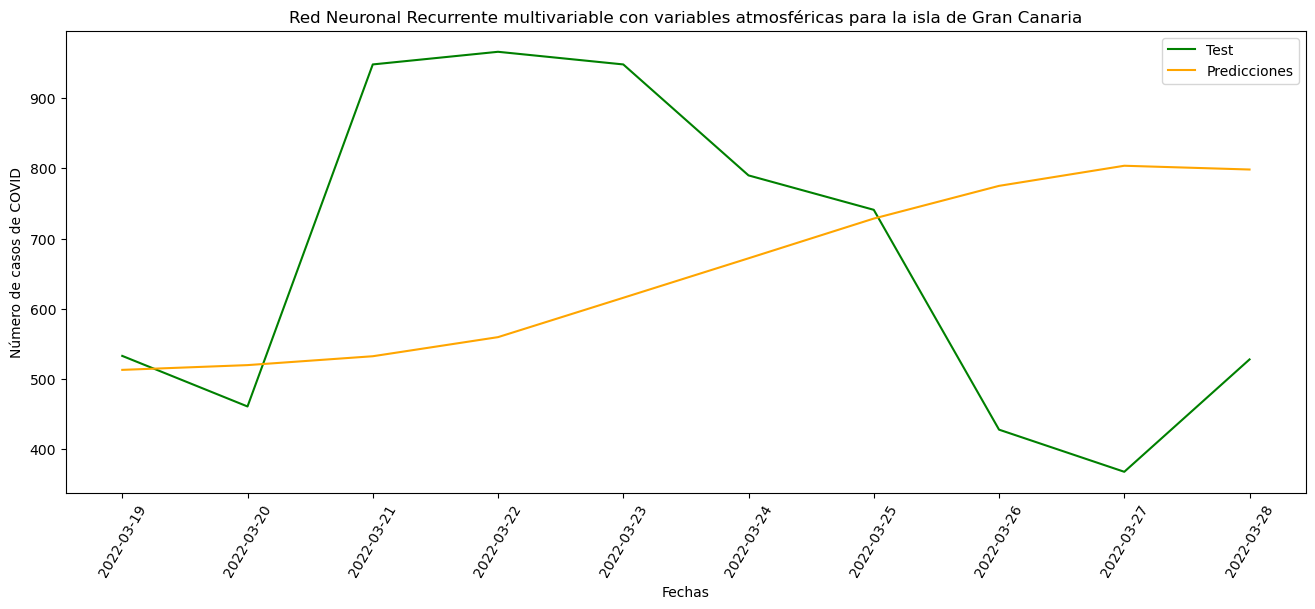

In [32]:
tit = 'Red Neuronal Recurrente multivariable con variables atmosféricas para la isla de ' + isla

visualizar_pred_test(y_test, y_pred, fechas, tit)

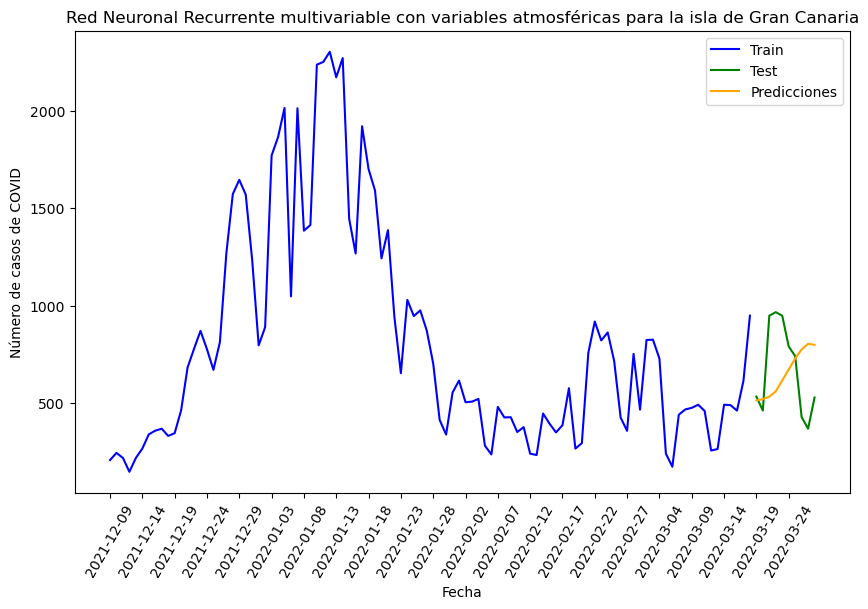

In [33]:
datos_train = datos_GranCanaria_mult_atm.iloc[:n_train, :]
visualizar_historico(datos_train,y_test,y_pred,objetivo,100,fechas,tit)

In [34]:
mae, mse, rmse = obtener_errores(y_test, y_pred)

print("Error cuadrático medio (MSE) del modelo: " + str(mse))
print("Error absoluto medio (MAE) del modelo: " + str(mae))
print("Raíz del error cuadrático medio (RMSE) del modelo: " + str(rmse))

Error cuadrático medio (MSE) del modelo: 84947.69971594363
Error absoluto medio (MAE) del modelo: 241.64775390625
Raíz del error cuadrático medio (RMSE) del modelo: 291.4578866936759


# Red Neuronal Recurrente multivariable con todas las variables

In [35]:
scaler = MinMaxScaler(feature_range=(0, 1))
datos_GranCanaria_mult_total_scaled = scaler.fit_transform(datos_GranCanaria_mult_total)

# Escalador par alas predicciones y test
scaler_preds = MinMaxScaler(feature_range=(0, 1))
datos_GranCanaria_mult_total_scaled_obj = scaler_preds.fit_transform(np.array(datos_GranCanaria_mult_total[objetivo]).reshape(-1, 1))

In [36]:
n_train = len(datos_GranCanaria_mult_total_scaled) - dias_prediccion


train = datos_GranCanaria_mult_total_scaled[0:n_train, :]

# Para obtener el conjunto de test obtenemos los 10 días anteriores a test para poder conformar el problema supervisado
test = datos_GranCanaria_mult_total_scaled[n_train - dias_prediccion:len(datos_GranCanaria_mult_total_scaled), :]

In [37]:
X_train, y_train = get_X_y(train, dias_prediccion)
X_test, y_test = get_X_y(test, dias_prediccion)

X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], X_train.shape[2]))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], X_test.shape[2]))

In [38]:
modelo = obtener_modelo_red_neuronal(X_train, y_train, X_test, y_test)

Epoch 1/50


C:\Users\jalon\anaconda3\envs\tfm\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 5s 127ms/step - loss: 0.0644 - val_loss: 0.0624
Epoch 2/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0425 - val_loss: 0.0481
Epoch 3/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0352 - val_loss: 0.0467
Epoch 4/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0315 - val_loss: 0.0412
Epoch 5/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0257 - val_loss: 0.0477
Epoch 6/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0255 - val_loss: 0.0415
Epoch 7/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0250 - val_loss: 0.0432
Epoch 8/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0227 - val_loss: 0.0299
Epoch 9/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0238 - val_loss: 0.0292
Epoch 10/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0210 - val_loss: 0.0351
Epoch 11/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0227 - val_loss: 0.0447
Epoch 12/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0201 - val_loss: 0.0330
Epoch 13/50

In [39]:
test_pred = modelo.predict(X_test)
y_pred = scaler_preds.inverse_transform(test_pred)
y_test = scaler_preds.inverse_transform(y_test.reshape(-1,1))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 439ms/step


In [40]:
visualizar_resultados_texto(y_test, y_pred, fechas)

array([[373.43073],
       [387.84326],
       [389.85223],
       [416.95618],
       [507.0909 ],
       [591.5599 ],
       [630.6832 ],
       [646.7812 ],
       [685.1652 ],
       [691.3955 ]], dtype=float32)

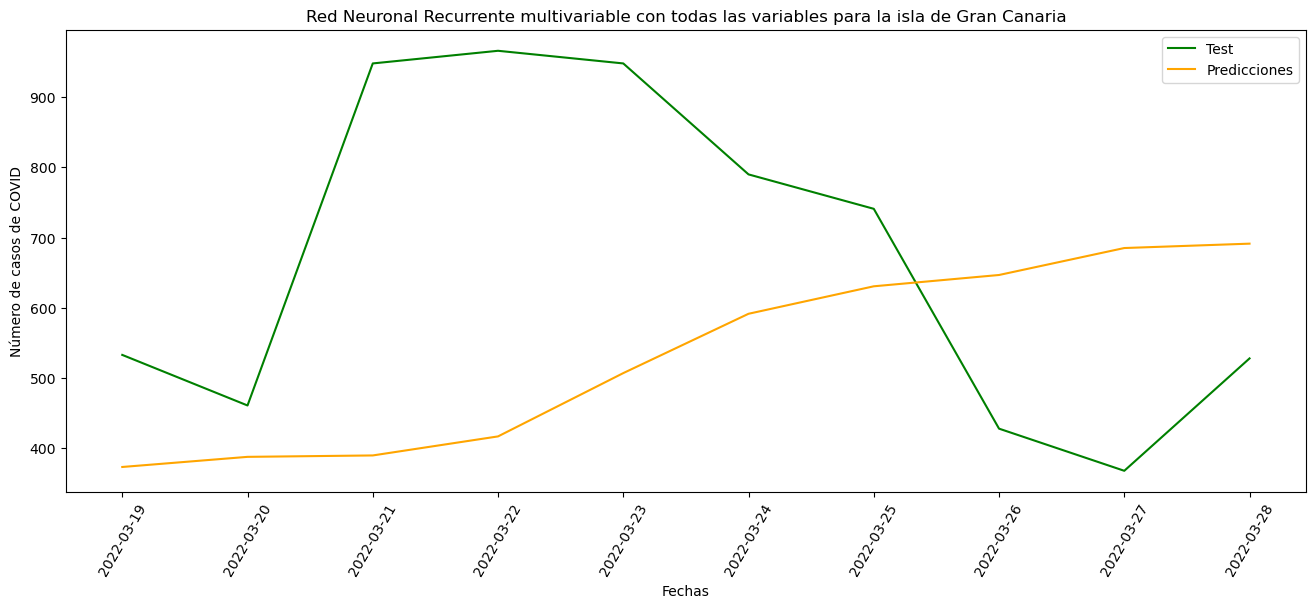

In [41]:
tit = 'Red Neuronal Recurrente multivariable con todas las variables para la isla de ' + isla

visualizar_pred_test(y_test, y_pred, fechas, tit)

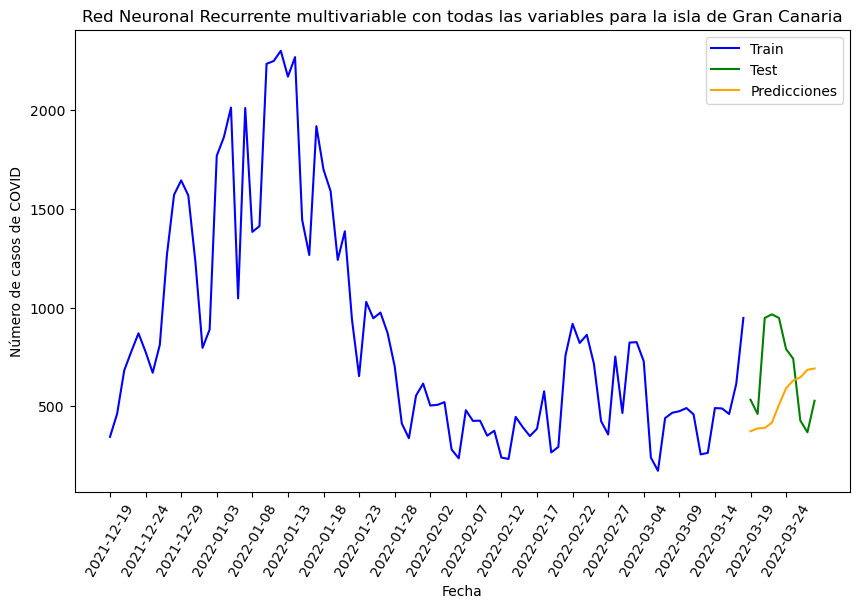

In [42]:
datos_train = datos_GranCanaria_mult_total.iloc[:n_train, :]
visualizar_historico(datos_train,y_test,y_pred,objetivo,90,fechas,tit)

In [43]:
mae, mse, rmse = obtener_errores(y_test, y_pred)

print("Error cuadrático medio (MSE) del modelo: " + str(mse))
print("Error absoluto medio (MAE) del modelo: " + str(mae))
print("Raíz del error cuadrático medio (RMSE) del modelo: " + str(rmse))

Error cuadrático medio (MSE) del modelo: 106489.84865797432
Error absoluto medio (MAE) del modelo: 278.8925506591797
Raíz del error cuadrático medio (RMSE) del modelo: 326.327823910212
